# Notebook 05 – Clustering Analysis

**Author:** Demetrios Agourakis  
**ORCID:** [0000-0002-8596-5097](https://orcid.org/0000-0002-8596-5097)  
**License:** MIT License  
**Code DOI:** [10.5281/zenodo.16752238](https://doi.org/10.5281/zenodo.16752238)  
**Data DOI:** [10.17605/OSF.IO/2AQP7](https://doi.org/10.17605/OSF.IO/2AQP7)  
**Version:** 1.0 – Last updated: 2025-08-07

This notebook selects an **optimal number of clusters** for the symbolic embedding space via **silhouette analysis** and fits a final KMeans model.  
Outputs include the chosen `n_clusters`, per-node labels, and diagnostic plots.


In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)


def get_root_path():
    current = Path.cwd()
    while current != current.parent:
        if (current / "README.md").exists():
            return current
        current = current.parent
    return Path.cwd()


ROOT = get_root_path()
DATA = ROOT / "data"
RESULTS = ROOT / "results"
DATA.mkdir(exist_ok=True)
RESULTS.mkdir(exist_ok=True)

merged_path = DATA / "symbolic_metrics_embeddings.csv"
if not merged_path.exists():
    raise FileNotFoundError(f"Missing merged dataset at: {merged_path}")

df = pd.read_csv(merged_path)
print(f"Merged dataset loaded: {df.shape}")
df.head()

Merged dataset loaded: (77163, 139)


,node,in_degree,out_degree,total_degree,in_strength,out_strength,total_strength,pagerank,closeness,betweenness,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,there,84,36,120,238.0,113.0,351.0,0.000100,0.056718,0.000057,...,-0.208297,0.191555,0.054995,-0.328719,-0.102927,-0.063031,-0.139056,-0.034042,-0.285167,0.024825
1,position,83,62,145,158.0,119.0,277.0,0.000046,0.057992,0.000128,...,-0.160407,-0.073331,0.167797,-0.135133,-0.140792,0.005810,-0.108114,0.119782,-0.058968,-0.023226
2,true,161,36,197,504.0,115.0,619.0,0.000150,0.059237,0.000075,...,0.002440,-0.002906,-0.113090,0.016463,-0.006559,-0.034161,-0.044763,0.099563,0.082961,0.089605
3,honest,108,51,159,453.0,112.0,565.0,0.000084,0.057231,0.000099,...,-0.039796,0.052120,-0.083340,0.070672,0.214605,-0.025857,-0.074921,0.076047,0.180430,0.143099
4,beat,100,52,152,276.0,113.0,389.0,0.000079,0.057367,0.000127,...,0.002254,0.008646,-0.004605,0.028234,-0.011257,-0.023648,-0.036888,-0.022101,-0.003045,-0.005218


In [2]:
# Identify embedding columns
emb_cols = [c for c in df.columns if c.startswith("emb_")]
if len(emb_cols) == 0:
    raise RuntimeError(
        "No embedding columns found (expected columns starting with 'emb_')."
    )

X = df[emb_cols].values

# Optional scaling (embeddings are L2-normalized by Notebook 03; keep identity transform)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

print(f"Embedding matrix shape: {X.shape}")

Embedding matrix shape: (77163, 128)


In [3]:
# Range of k to evaluate
K_MIN, K_MAX = 2, 20
sil_scores = []

for k in range(K_MIN, K_MAX + 1):
    km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels, metric="euclidean")
    sil_scores.append({"k": k, "silhouette": score})

sil_df = pd.DataFrame(sil_scores)
print(sil_df)

# Choose k maximizing silhouette
best_row = sil_df.loc[sil_df["silhouette"].idxmax()]
BEST_K = int(best_row["k"])
BEST_SIL = float(best_row["silhouette"])
print(f"Best k by silhouette: k={BEST_K} (score={BEST_SIL:.4f})")

     k  silhouette
0    2    0.780643
1    3    0.804245
2    4    0.806456
3    5    0.807902
4    6    0.809236
5    7    0.810468
6    8    0.813494
7    9    0.816019
8   10    0.815753
9   11    0.817560
10  12    0.815434
11  13    0.814853
12  14    0.816955
13  15    0.818177
14  16    0.827918
15  17    0.821048
16  18    0.828763
17  19    0.828199
18  20    0.825196
Best k by silhouette: k=18 (score=0.8288)


Silhouette scores saved to: /Users/demetriosagourakis/Library/Mobile Documents/com~apple~CloudDocs/Biologia Fractal/entropic-symbolic-society/NHB_Symbolic_Mainfold/data/silhouette_scores.csv


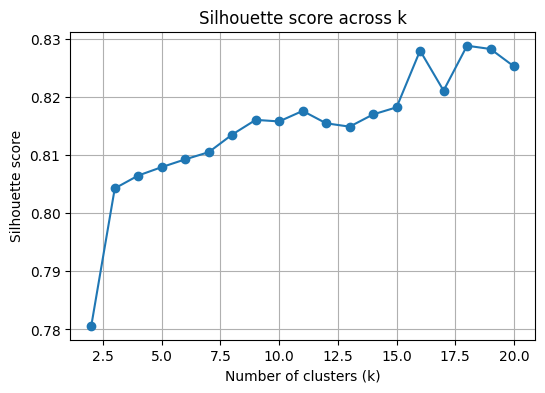

Silhouette plot saved to: /Users/demetriosagourakis/Library/Mobile Documents/com~apple~CloudDocs/Biologia Fractal/entropic-symbolic-society/NHB_Symbolic_Mainfold/results/silhouette_scores.png


In [4]:
# Save table of silhouette scores
sil_csv = DATA / "silhouette_scores.csv"
sil_df.to_csv(sil_csv, index=False)
print(f"Silhouette scores saved to: {sil_csv}")

# Plot silhouette vs k
plt.figure(figsize=(6, 4))
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score across k")
plt.grid(True)
plot_path = RESULTS / "silhouette_scores.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Silhouette plot saved to: {plot_path}")

In [5]:
# Fit final KMeans with BEST_K
final_km = KMeans(n_clusters=BEST_K, n_init=10, random_state=SEED)
final_labels = final_km.fit_predict(X)

# Save labels alongside node identifiers
labels_df = pd.DataFrame({"node": df["node"].values, "cluster": final_labels})
labels_csv = DATA / "labels.csv"
labels_df.to_csv(labels_csv, index=False)
print(f"Cluster labels saved to: {labels_csv}")

# Save optimal clusters metadata
meta = {"n_clusters": BEST_K, "silhouette": BEST_SIL, "method": "kmeans", "seed": SEED}
meta_json = DATA / "optimal_clusters.json"
with open(meta_json, "w") as f:
    json.dump(meta, f, indent=2)
print(f"Optimal clusters metadata saved to: {meta_json}")

Cluster labels saved to: /Users/demetriosagourakis/Library/Mobile Documents/com~apple~CloudDocs/Biologia Fractal/entropic-symbolic-society/NHB_Symbolic_Mainfold/data/labels.csv
Optimal clusters metadata saved to: /Users/demetriosagourakis/Library/Mobile Documents/com~apple~CloudDocs/Biologia Fractal/entropic-symbolic-society/NHB_Symbolic_Mainfold/data/optimal_clusters.json


## ✅ Notebook Summary

We evaluated KMeans clustering across a range of `k` values using the silhouette criterion and selected the best `k`.  
Artifacts saved:
- `data/silhouette_scores.csv` — per-k silhouette values
- `results/silhouette_scores.png` — diagnostic plot
- `data/labels.csv` — per-node cluster assignments
- `data/optimal_clusters.json` — chosen `n_clusters` and metadata

---

## ▶️ Next Step

Proceed to **Notebook 06 – UMAP Visualization**, where we will project embeddings to 2D using UMAP and visualize clusters using the chosen `n_clusters`.
